<a href="https://colab.research.google.com/github/youngchul-sung/deep-learning-with-python/blob/master/8_2_deep_dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
from tensorflow import keras

keras.__version__

TensorFlow 2.x selected.


'2.2.4-tf'

In [2]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K

# 모델을 훈련하지 않습니다. 이 명령은 모든 훈련 연산을 비활성화합니다
K.set_learning_phase(0)

# 합성곱 기반층만 사용한 인셉션 V3 네트워크를 만듭니다. 사전 훈련된 ImageNet 가중치와 함께 모델을 로드합니다
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
# 층 이름과 계수를 매핑한 딕셔너리.
# 최대화하려는 손실에 층의 활성화가 기여할 양을 정합니다.
# 층 이름은 내장된 인셉션 V3 애플리케이션에 하드코딩되어 있는 것입니다.
# model.summary()를 사용하면 모든 층 이름을 확인할 수 있습니다
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [0]:
import os

if not os.path.exists('deep-learning-with-python-notebooks'):
    !git clone https://github.com/rickiepark/deep-learning-with-python-notebooks.git

In [5]:
from tensorflow.keras import models

dream = model.input

def fetch_loss_and_grads(x):
    with tf.GradientTape() as gtape:
        # 층 이름과 층 객체를 매핑한 딕셔너리를 만듭니다.
        layer_dict = dict([(layer.name, layer) for layer in model.layers])
        
        target_paths = dict()
        for layer_name in layer_contributions:
            target_paths[layer_name] = models.Model([model.input], [layer_dict[layer_name].output])

        # 손실을 정의하고 각 층의 기여분을 이 스칼라 변수에 추가할 것입니다
        loss = 0.
        for layer_name in layer_contributions:
            coeff = layer_contributions[layer_name]
            # 층의 출력을 얻습니다
            layer_output = target_paths[layer_name]([x])
            activation = layer_output

            scaling = K.prod(K.cast(K.shape(activation), 'float32'))
            # 층 특성의 L2 노름의 제곱을 손실에 추가합니다. 이미지 테두리는 제외하고 손실에 추가합니다.
            layer_loss = coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling
            # print(layer_name, scaling, layer_loss)
            loss += layer_loss

        grads = gtape.gradient(loss, [x])[0]
        grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

    return [loss, grads]

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads(x)
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 이 함수는 경사 상승법을 여러 번 반복하여 수행합니다
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        print(loss_value, max_loss)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x.assign_add(step * grad_values)

    return x


import scipy
from tensorflow.keras.preprocessing import image

def resize_img(img, size):
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(img)
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(img):
    x = img
    # 넘파이 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원합니다
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


import numpy as np
import tensorflow as tf

# 하이퍼파라미터를 바꾸면 새로운 효과가 만들어집니다
step = 0.01  # 경상 상승법 단계 크기
num_octave = 3  # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4  # 스케일 간의 크기 비율
iterations = 20  # 스케일 단계마다 수행할 경사 상승법 횟수

# 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해 경사 상승법 과정을 중지합니다
max_loss = 10.

# 사용할 이미지 경로를 씁니다
base_image_path = 'deep-learning-with-python-notebooks/datasets/original_photo_deep_dream.jpg'

# 기본 이미지를 넘파이 배열로 로드합니다
img = preprocess_image(base_image_path)

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비합니다
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 이 리스트를 크기 순으로 뒤집습니다
successive_shapes = successive_shapes[::-1]

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경합니다
original_img = np.copy(img)
shrunk_img = resize_img(img, successive_shapes[0])

for i, shape in enumerate(successive_shapes):
    print('처리할 이미지 크기', shape)
    # print(type(img))
    img = tf.Variable(tf.cast(shrunk_img, tf.float32))
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    img = img.numpy()

    if i+1 < len(successive_shapes):
        up_shape = successive_shapes[i+1]
        upscaled_shrunk_img = resize_img(img, up_shape)
        same_size_original = resize_img(original_img, up_shape)
        lost_detail = same_size_original - upscaled_shrunk_img

        shrunk_img = upscaled_shrunk_img
        shrunk_img += lost_detail

    save_img(np.copy(img), fname='dream_at_scale_' + str(shape) + '.png')

save_img(np.copy(img), fname='final_dream.png')

처리할 이미지 크기 (178, 178)
tf.Tensor(0.65961766, shape=(), dtype=float32) 10.0
... 0 번째 손실 : tf.Tensor(0.65961766, shape=(), dtype=float32)
tf.Tensor(1.0167829, shape=(), dtype=float32) 10.0
... 1 번째 손실 : tf.Tensor(1.0167829, shape=(), dtype=float32)
tf.Tensor(1.468085, shape=(), dtype=float32) 10.0
... 2 번째 손실 : tf.Tensor(1.468085, shape=(), dtype=float32)
tf.Tensor(2.004862, shape=(), dtype=float32) 10.0
... 3 번째 손실 : tf.Tensor(2.004862, shape=(), dtype=float32)
tf.Tensor(2.6124346, shape=(), dtype=float32) 10.0
... 4 번째 손실 : tf.Tensor(2.6124346, shape=(), dtype=float32)
tf.Tensor(3.0966427, shape=(), dtype=float32) 10.0
... 5 번째 손실 : tf.Tensor(3.0966427, shape=(), dtype=float32)
tf.Tensor(3.5745823, shape=(), dtype=float32) 10.0
... 6 번째 손실 : tf.Tensor(3.5745823, shape=(), dtype=float32)
tf.Tensor(4.06222, shape=(), dtype=float32) 10.0
... 7 번째 손실 : tf.Tensor(4.06222, shape=(), dtype=float32)
tf.Tensor(4.501116, shape=(), dtype=float32) 10.0
... 8 번째 손실 : tf.Tensor(4.501116, shape=(), dt

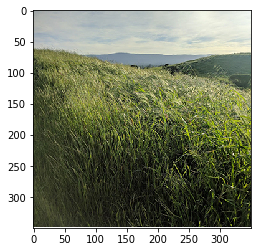

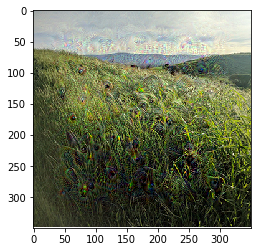

In [6]:
from matplotlib import pyplot as plt

plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()